# Signal Combinations

Apply the ionfree combination on data from a RINEX file.

# Libraries

In [ ]:
!pip install georinex

     |████████████████████████████████| 50 kB 5.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for georinex: filename=georinex-1.15.1-py3-none-any.whl size=52018 sha256=4b95c4a2c7e155de7af807d0fd7a3d3b59b431491358d150331dbf636956382f
  Stored in directory: /root/.cache/pip/wheels/fa/f5/f3/a0b697b437e10561fb6a4546e3d5c4cc5fb073fe746dddd04c
Successfully built georinex


In [ ]:
import georinex as gr
import numpy as np
import xarray as xr
from scipy.constants import c

import requests
from datetime import datetime
import erfa
from zipfile import ZipFile
import urllib
import itertools

from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

# Combinations

In [ ]:
def m1m2_PRionfree(f1,f2):
  return f1**2/(f1**2-f2**2),-f2**2/(f1**2-f2**2)

def m1m2_Phiionfree(f1,f2):
  return f1**2/(f1**2-f2**2),-f1*f2/(f1**2-f2**2)

def m1m2_PRwidelane(f1,f2):
  return f1/(f1-f2),-f2/(f1-f2)

def m1m2_PRgeomfree(f1,f2):
  return 1,-1

def m1m2_PRnarrowlane(f1,f2):
  return f1/(f1+f2),f2/(f1+f2)

def sigmaMultiplier(m1,m2):
  return np.sqrt(m1**2+m2**2)

frequencies={
'L1':	1575.42,
'L2':	1227.6,
'L5':	1176.45,
'G1':	1602,
'G2':	1246,
'G3':	1202.025,
'E1':	1575.42,
'E5b':	1207.14,
'E5a':	1176.45
}

In [ ]:
gpsfreqs=['L1','L2','L5']
print("Signal1 Signal2 m1 m2 sigma")
for pair in itertools.combinations(gpsfreqs, 2): 
  f1=frequencies[pair[0]]
  f2=frequencies[pair[1]]
  m1,m2=m1m2_Phiionfree(f1,f2)
  sigmaMult=sigmaMultiplier(m1,m2)
  print(pair[0],pair[1],m1,m2,sigmaMult)

Signal1 Signal2 m1 m2 sigma
L1 L2 2.5457277801631593 -1.9836839845427212 3.227341333237892
L1 L5 2.2606043275188257 -1.688113621199123 2.8213577447170466
L2 L5 12.255319148936195 -11.744680851063855 16.974403545798836


In [ ]:
fa=frequencies['L1']
fb=frequencies['L2']
sigmaMult=np.sqrt(fa**2+fb**2)/(fa+fb)
print("Wide-lane sigma multiplier:", sigmaMult)

Wide-lane sigma multiplier: 0.7125299047408336


# Processing RINEX data

In [ ]:
#CHANGE THIS TO use other dates. This is the reference date that is going to be used to download the navigation and precise ephemeris files.
#epoch=np.datetime64('2021-01-10T23:45:00') 
epoch=np.datetime64('2021-05-10T23:45:00') 
#epoch=np.datetime64('2020-08-10T23:45:00') 
#station="ONRJ"
station="RJNI"

## Helper functions

In [ ]:
!git clone https://github.com/mauriciodev/spatialgeodesy.git
from spatialgeodesy import gnsstime

Cloning into 'spatialgeodesy'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 18 (delta 5), reused 12 (delta 3), pack-reused 0
Unpacking objects: 100% (18/18), done.


In [ ]:
def getDOY(t):
  year=t.astype('datetime64[Y]')
  dayOfYear=((t-year)/np.timedelta64(1,'D')+1).astype(np.int64)
  return dayOfYear

def getBRDC(t):
  doy=getDOY(t)
  year=np.datetime64(t,'Y')#t.astype('datetime64[Y]')
  #baseurl="ftp://gssc.esa.int/gnss/data/daily/{0}/{1:03}/brdc{1:03}0.{2}n.Z".format(str(year),doy,str(year)[:-2])
  
  baseurl="https://igs.bkg.bund.de/root_ftp/IGS/BRDC/{0}/{1:03}/BRDM00DLR_S_{0}{1:03}0000_01D_MN.rnx.gz".format(str(year),doy)
  local_filename = baseurl.split('/')[-1]
  print("Downloading from BKG ", baseurl)
  response = requests.get(baseurl)
  open(local_filename, 'wb').write(response.content)
  print("Saved ",local_filename)
  return local_filename

def getSecsOfWeek(t):
  today=t.astype('datetime64[D]')
  secsOfDay=(t-today)/ np.timedelta64(1, 's')
  dayOfWeek=(today.astype(np.int64) - 3) % 7
  secsOfWeek=secsOfDay+dayOfWeek*24*60*60
  return secsOfWeek

## Downloading data

In [ ]:
#def getRBMC(t,station):
t=epoch
def getRBMC(t,station, rinexversion=3):
    doy=getDOY(t)
    year=np.datetime64(t,'Y')#t.astype('datetime64[Y]')
    if rinexversion==3:
        baseurl="https://geoftp.ibge.gov.br/informacoes_sobre_posicionamento_geodesico/rbmc/dados_RINEX3/{0}/{1:03}/{2}00BRA_R_{0}{1:03}0000_01D_15S_MO.crx.gz".format(str(year),doy,station)
    else:
        baseurl="https://geoftp.ibge.gov.br/informacoes_sobre_posicionamento_geodesico/rbmc/dados/{0}/{1:03}/{2}{1:03}1.zip".format(str(year),doy,station.lower() )
    local_filename = baseurl.split('/')[-1]
    print("Downloading from IBGE ", baseurl)
    response = requests.get(baseurl)
    open(local_filename, 'wb').write(response.content)
    print("Saved ",local_filename)
    print("Unzipping")
    with ZipFile(local_filename, 'r') as zipObj:
        outdir=local_filename.split('.')[0]
        zipObj.extractall(outdir)
        files=zipObj.namelist()
        files = [ outdir+ "/"+ sub for sub in files]
    return files
stationFiles=getRBMC(epoch,station,2)

Saved  rjni1301.zip
Unzipping


In [ ]:
#we are using rinex 2 because georinex is incredibly slow for rinex 3 currently.
obsFile=list(filter(lambda f: f[-1]=='d',stationFiles))[0]
obsData=gr.load(obsFile)
obsData

cc /usr/local/lib/python3.7/dist-packages/georinex/rnxcmp/source/crx2rnx.c -O2 -o/usr/local/lib/python3.7/dist-packages/georinex/rnxcmp/crx2rnx


<xarray.Dataset>
Dimensions:  (sv: 79, time: 5760)
Coordinates:
  * sv       (sv) object 'E01' 'E02' 'E03' 'E04' ... 'R21' 'R22' 'R23' 'R24'
  * time     (time) object 2021-05-10 ... 2021-05-10T23:59:45
Data variables: (12/17)
    C1       (time, sv) float64 nan 2.634e+07 2.518e+07 ... 1.948e+07 2.118e+07
    C2       (time, sv) float64 nan nan nan nan ... nan 2.246e+07 nan 2.118e+07
    C5       (time, sv) float64 nan 2.634e+07 2.518e+07 nan ... nan nan nan nan
    C7       (time, sv) float64 nan 2.634e+07 2.518e+07 nan ... nan nan nan nan
    C8       (time, sv) float64 nan 2.634e+07 2.518e+07 nan ... nan nan nan nan
    L1       (time, sv) float64 nan 1.384e+08 1.323e+08 ... 1.042e+08 1.133e+08
    ...       ...
    P2       (time, sv) float64 nan nan nan nan ... nan 2.246e+07 nan 2.118e+07
    S1       (time, sv) float64 nan 44.4 47.4 nan 47.5 ... nan 32.4 50.5 49.2
    S2       (time, sv) float64 nan nan nan nan nan ... nan nan 30.0 nan 45.2
    S5       (time, sv) float64 nan 45.4 49.7 nan 47.2 ... nan nan nan nan nan
    S7       (time, sv) float64 nan 45.2 49.3 nan 46.8 ... nan nan nan nan nan
    S8       (time, sv) float64 nan 48.9 53.0 nan 50.1 ... nan nan nan nan nan
Attributes:
    version:          1.0
    interval:         15.0
    rinextype:        obs
    fast_processing:  1
    time_system:      GPS
    filename:         rjni1301.21d
    rxmodel:          TRIMBLE NETR9
    position:         [4289663.4011, -4018945.7498, -2467135.8382]

## Performing the ionfree combination

In [ ]:
f1Name='L1'  
f2Name='L2'  
f1=frequencies[f1Name]
f2=frequencies[f2Name]
m1,m2=m1m2_PRionfree(f1,f2)
#obsData['ionfree_phi'+f1Name+f2Name]=m1*obsData['L1']+m2*obsData['L2']
obsData['ionfree_r'+f1Name+f2Name]=m1*obsData['C1']+m2*obsData['P2']

In [ ]:
obsData

<xarray.Dataset>
Dimensions:        (sv: 79, time: 5760)
Coordinates:
  * sv             (sv) object 'E01' 'E02' 'E03' 'E04' ... 'R22' 'R23' 'R24'
  * time           (time) object 2021-05-10 ... 2021-05-10T23:59:45
Data variables: (12/18)
    C1             (time, sv) float64 nan 2.634e+07 ... 1.948e+07 2.118e+07
    C2             (time, sv) float64 nan nan nan ... 2.246e+07 nan 2.118e+07
    C5             (time, sv) float64 nan 2.634e+07 2.518e+07 ... nan nan nan
    C7             (time, sv) float64 nan 2.634e+07 2.518e+07 ... nan nan nan
    C8             (time, sv) float64 nan 2.634e+07 2.518e+07 ... nan nan nan
    L1             (time, sv) float64 nan 1.384e+08 ... 1.042e+08 1.133e+08
    ...             ...
    S1             (time, sv) float64 nan 44.4 47.4 nan ... nan 32.4 50.5 49.2
    S2             (time, sv) float64 nan nan nan nan nan ... nan 30.0 nan 45.2
    S5             (time, sv) float64 nan 45.4 49.7 nan 47.2 ... nan nan nan nan
    S7             (time, sv) float64 nan 45.2 49.3 nan 46.8 ... nan nan nan nan
    S8             (time, sv) float64 nan 48.9 53.0 nan 50.1 ... nan nan nan nan
    ionfree_rL1L2  (time, sv) float64 nan nan nan ... 2.246e+07 nan 2.118e+07
Attributes:
    version:          1.0
    interval:         15.0
    rinextype:        obs
    fast_processing:  1
    time_system:      GPS
    filename:         rjni1301.21d
    rxmodel:          TRIMBLE NETR9
    position:         [4289663.4011, -4018945.7498, -2467135.8382]

[]

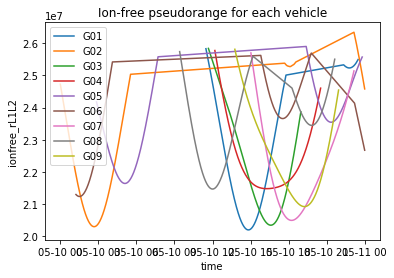

In [ ]:
ionfree=obsData['ionfree_rL1L2']
#cleaning epochs without data
#g01_ionfree=g01_ionfree.dropna(dim='time')

for sat in range(1,10):
  sv="G{:02d}".format(sat)
  if sv in obsData.sv:
    subset=ionfree.sel(sv=sv).dropna(dim='time')
    subset.plot(label=sv)
plt.title("Ion-free pseudorange for each vehicle")
plt.legend()
plt.plot()

# Sat DCB

In [ ]:
!pip install unlzw
import unlzw

  Created wheel for unlzw: filename=unlzw-0.1.1-cp37-cp37m-linux_x86_64.whl size=21441 sha256=94e878f121616badca454a99bbbeff7d2fb34bb06073fd66efc87d2eee7c9f9a
  Stored in directory: /root/.cache/pip/wheels/6e/36/71/0956632d0fc14c99edc168063b7ff06c3462e19855a0df36db
Successfully built unlzw


In [ ]:
import urllib.request

def getDCB(t):
  doy=gnsstime.getDayOfYear(epoch)
  year=gnsstime.getYear(epoch)
  #baseurl="https://igs.bkg.bund.de/root_ftp/IGS/products/dcb/p1c1{0:02d}{1:02d}.dcb.Z".format(year,month)
  baseurl="ftp://igs.ign.fr/pub/igs/products/mgex/dcb/{0}/CAS0MGXRAP_{0}{1}0000_01D_01D_DCB.BSX.gz".format(year,doy)
  local_filename = baseurl.split('/')[-1]
  print("Downloading from BKG ", baseurl)
  urllib.request.urlretrieve(baseurl,local_filename)
  print("Saved ",local_filename)
  return local_filename

import zlib
from io import StringIO
import re
import pandas as pd
def readDCB(dcbFile):
  compressed_data = open(dcbFile, 'rb').read()
  decompressed_data = zlib.decompress(compressed_data, zlib.MAX_WBITS | 16).decode()
  bias=re.findall("\+BIAS/SOLUTION.*?\-BIAS/SOLUTION", decompressed_data, re.DOTALL)[0]
  return pd.read_fwf(StringIO(bias),skiprows=1)
  

dcbFile=getDCB(epoch)
dcbDF=readDCB(dcbFile)
dcbDF

Saved  CAS0MGXRAP_20211300000_01D_01D_DCB.BSX.gz


,*BIAS,SVN_,PRN,STATION__,OBS1,OBS2,BIAS_START____,BIAS_END______,UNIT,__ESTIMATED_VALUE____,_STD_DEV___
0,DSB,G063,G01,NaN,C1C,C1W,2021:130:00000,2021:131:00000,ns,-1.147,0.0070
1,DSB,G061,G02,NaN,C1C,C1W,2021:130:00000,2021:131:00000,ns,1.703,0.0070
2,DSB,G069,G03,NaN,C1C,C1W,2021:130:00000,2021:131:00000,ns,-1.416,0.0070
3,DSB,G074,G04,NaN,C1C,C1W,2021:130:00000,2021:131:00000,ns,-0.843,0.0070
4,DSB,G050,G05,NaN,C1C,C1W,2021:130:00000,2021:131:00000,ns,-0.869,0.0070
...,...,...,...,...,...,...,...,...,...,...,...
5140,DSB,J,J,ULAB,C1X,C5X,2021:130:00000,2021:131:00000,ns,10.255,0.2180
5141,DSB,J,J,URUM,C1X,C5X,2021:130:00000,2021:131:00000,ns,13.699,0.2165
5142,DSB,J,J,WUH2,C1X,C5X,2021:130:00000,2021:131:00000,ns,6.614,0.1845
5143,DSB,J,J,YAR2,C1X,C5X,2021:130:00000,2021:131:00000,ns,-4.175,0.1855


In [ ]:
dcbDF['dcbid']= dcbDF['OBS1']+dcbDF['OBS2']
#Listing available biases
dcbDF[(dcbDF.PRN=="G03")]
#C1C-C1W + C1W-C2W - (C2C-C2W)
dcbDF.pivot(index='PRN', columns='dcbid', values='__ESTIMATED_VALUE____')


ValueError: ignored

# Bonus: Geometry-free

[]

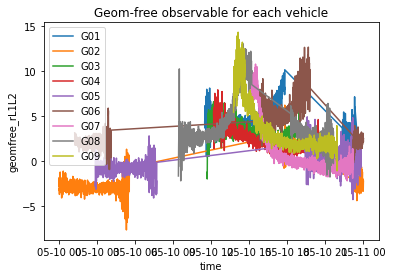

In [ ]:
obsData['geomfree_r'+f1Name+f2Name]=obsData['P2']-obsData['C1']
geomfree=obsData['geomfree_rL1L2']
#cleaning epochs without data
#g01_ionfree=g01_ionfree.dropna(dim='time')

for sat in range(1,10):
  sv="G{:02d}".format(sat)
  if sv in obsData.sv:
    subset=geomfree.sel(sv=sv).dropna(dim='time')
    subset.plot(label=sv)
plt.title("Geom-free observable for each vehicle")
plt.legend()
plt.plot()

[]

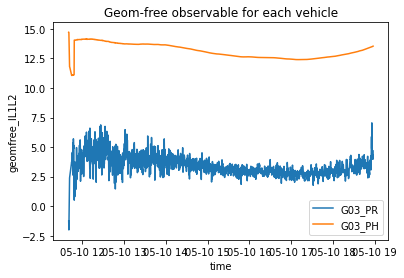

In [ ]:
obs1='L1'
obs2='L2'
obsData['geomfree_l'+f1Name+f2Name]=c/1e6 /frequencies[obs1] * obsData[obs1]- c/1e6 /frequencies[obs2] *obsData[obs2]
obsData['geomfree_r'+f1Name+f2Name]=obsData['P2']-obsData['C1']

sv="G03"


alpha=40.3*1e16*(frequencies[obs2]**-2-frequencies[obs1]**-2)
#cleaning epochs without data
#g01_ionfree=g01_ionfree.dropna(dim='time')

#for sat in range(1,10):
#sv="G{:02d}".format(sat)

if sv in obsData.sv:
  subset=obsData['geomfree_rL1L2'].sel(sv=sv).dropna(dim='time')
  subset.plot(label=sv+"_PR")
  subset=obsData['geomfree_lL1L2'].sel(sv=sv).dropna(dim='time')
  subset.plot(label=sv+"_PH")
plt.title("Geom-free observable for each vehicle")
plt.legend()
plt.plot()

In [ ]:
satdcb*c

-1.8350296354180002

[]

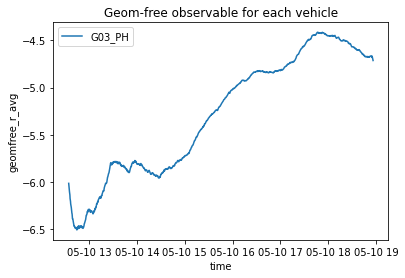

In [ ]:
recdcb=0
sv="G03"

#Sat DCB
satdcb=dcbDF[(dcbDF.PRN==sv) & (dcbDF.OBS1=='C1C') & (dcbDF.OBS2=='C2W')].__ESTIMATED_VALUE____.values[0]*1e-9
satdcb

obsData['geomfree_r_avg']=obsData['geomfree_lL1L2']-(obsData['geomfree_lL1L2']+obsData['geomfree_rL1L2']).rolling(time=200).mean()+satdcb*c - recdcb*c
geomfreer=obsData['geomfree_r_avg']
if sv in obsData.sv:
  subset=geomfreer.sel(sv=sv).dropna(dim='time')
  subset.plot(label=sv+"_PH")
plt.title("Geom-free observable for each vehicle")
plt.legend()
plt.plot()

In [ ]:
obsData['geomfree_r_avg']

<xarray.DataArray 'geomfree_r_avg' (time: 5760, sv: 79)>
array([[          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       ...,
       [          nan,           nan,           nan, ...,  157.23636071,
                  nan, -197.06582339],
       [          nan,           nan,           nan, ...,  157.61562019,
                  nan, -196.74211196],
       [          nan,           nan,           nan, ...,  158.00202608,
                  nan, -196.4123822 ]])
Coordinates:
  * sv       (sv) object 'E01' 'E02' 'E03' 'E04' ... 'R21' 'R22' 'R23' 'R24'
  * time     (time) object 2021-05-10 ... 2021-05-10T23:59:45

In [ ]:
geomfree=obsData['geomfree_lL1L2']
#cleaning epochs without data
#g01_ionfree=g01_ionfree.dropna(dim='time')

for sat in range(1,10):
  sv="G{:02d}".format(sat)
  if sv in obsData.sv:
    subset=geomfree.sel(sv=sv).dropna(dim='time')
    subset.plot(label=sv)
plt.title("Geom-free observable for each vehicle")
plt.legend()
plt.plot()

In [ ]:
obsData

<xarray.Dataset>
Dimensions:         (sv: 79, time: 5760)
Coordinates:
  * sv              (sv) object 'E01' 'E02' 'E03' 'E04' ... 'R22' 'R23' 'R24'
  * time            (time) object 2021-05-10 ... 2021-05-10T23:59:45
Data variables: (12/20)
    C1              (time, sv) float64 nan 2.634e+07 ... 1.948e+07 2.118e+07
    C2              (time, sv) float64 nan nan nan ... 2.246e+07 nan 2.118e+07
    C5              (time, sv) float64 nan 2.634e+07 2.518e+07 ... nan nan nan
    C7              (time, sv) float64 nan 2.634e+07 2.518e+07 ... nan nan nan
    C8              (time, sv) float64 nan 2.634e+07 2.518e+07 ... nan nan nan
    L1              (time, sv) float64 nan 1.384e+08 ... 1.042e+08 1.133e+08
    ...              ...
    S5              (time, sv) float64 nan 45.4 49.7 nan ... nan nan nan nan
    S7              (time, sv) float64 nan 45.2 49.3 nan ... nan nan nan nan
    S8              (time, sv) float64 nan 48.9 53.0 nan ... nan nan nan nan
    ionfree_rL1L2   (time, sv) float64 nan nan nan ... 2.246e+07 nan 2.118e+07
    geomfree_rL1L2  (time, sv) float64 nan nan nan nan ... nan -4.028 nan -3.903
    geomfree_lL1L2  (time, sv) float64 nan nan nan ... 4.224e+04 nan 3.992e+04
Attributes:
    version:          1.0
    interval:         15.0
    rinextype:        obs
    fast_processing:  1
    time_system:      GPS
    filename:         rjni1301.21d
    rxmodel:          TRIMBLE NETR9
    position:         [4289663.4011, -4018945.7498, -2467135.8382]